In [35]:
import torch
from src.utils import load_data, pad_window_interval
from src.tokenization import tokenize
from src.positional_encoding import positional_encoding
import src.transformer_model
from src.change_points import detect_changes
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from src.dataset import PTBXL
import matplotlib.pyplot as plt

In [2]:
path = './dataset/ecg/WFDB_PTBXL/ptbxl/'
sampling_rate=100
X_train, y_train, X_test, y_test = load_data(path, sampling_rate)

# preprocess data without labels
mask = y_train.apply(lambda x: isinstance(x, list) and len(x) > 0)
y_train = y_train[mask]
X_train = X_train[mask]
y_train = y_train.apply(lambda x: x[0]).astype('category')
y_train = torch.tensor(y_train.cat.codes.values, dtype=torch.long)

print(torch.unique(y_train))

tensor([0, 1, 2, 3, 4])


In [7]:
def normalize(data):
    # Compute mean and std per channel
    mean_vals = data.mean(axis=2, keepdims=True)
    std_vals = data.std(axis=2, keepdims=True)

    return (data - mean_vals) / (std_vals + 1e-8)


In [ ]:


import importlib
importlib.reload(src.transformer_model)
from src.transformer_model import TimeSeriesTransformer

window_size = None
overlap=10

model_inputs = []

# (19000, 1000, 12)
for time_series in X_train:
    # min max normalization
    time_series = normalize(time_series)
    change_points = detect_changes(time_series)

    # Tokenize the data
    tokens = tokenize(torch.from_numpy(time_series), window_size, overlap, change_points)

    # Generate positional encodings
    pos_encoding = positional_encoding(tokens.shape[0], tokens.shape[1]).unsqueeze(-1) # (4, 442, 1)
    
    model_input = torch.cat((tokens, pos_encoding), dim=-1)

    model_inputs.append(model_input)


padded_window_seq = pad_window_interval(model_inputs)
padded_input_seq = pad_sequence(padded_window_seq, batch_first=True)
padded_input_seq = padded_input_seq.float()


dataset = PTBXL(padded_input_seq, y_train)

dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
input_dim = 2756               # Number of features (12 channels + positional encoding) * window size
d_model = 64                  # Dimension of embeddings (output from transformer)
num_heads = 8                 # Number of attention heads
num_layers = 6                # Number of encoder layers
dim_feedforward = 256         # Feedforward layer dimension
dropout = 0.1                 # Dropout rate
num_classes = 5
model = TimeSeriesTransformer(
    input_dim=input_dim,
    d_model=d_model,
    num_heads=num_heads,
    num_layers=num_layers,
    dim_feedforward=dim_feedforward,
    dropout=dropout,
    num_classes=num_classes,
)
learning_rate = 0.001
num_epochs = 3

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



/opt/homebrew/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [34]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    # Wrap the dataloader with tqdm
    for inputs, labels in tqdm(dataloader, desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch'):
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs) # Forward pass
        loss = criterion(outputs, labels)  # Calculate loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        
        running_loss += loss.item()

    average_loss = running_loss / len(dataloader)
    print(f'Average Loss: {average_loss:.4f}')

print("Training complete!")

NameError: name 'num_epochs' is not defined

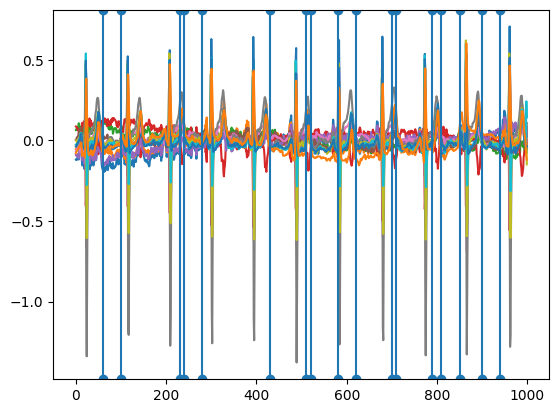

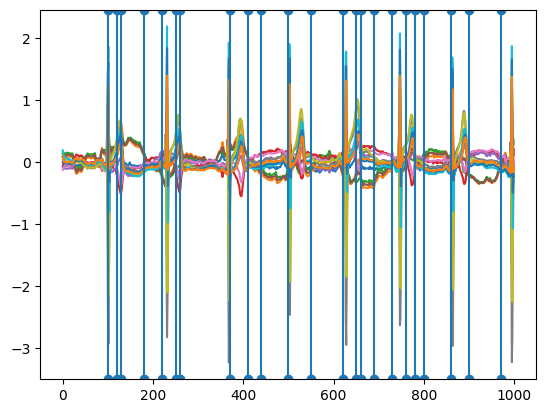

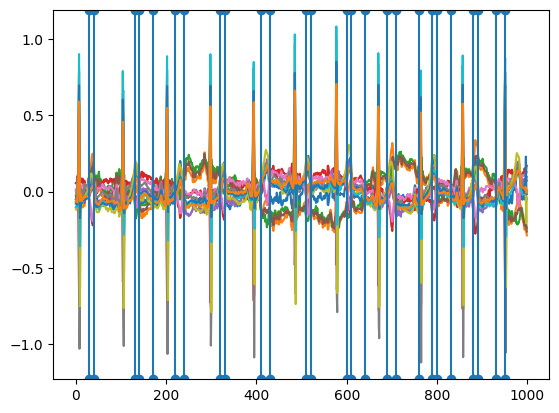

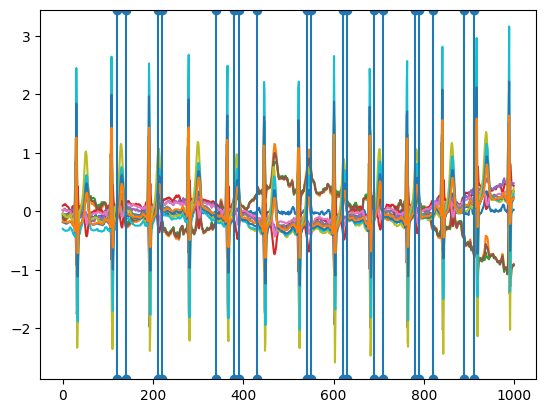

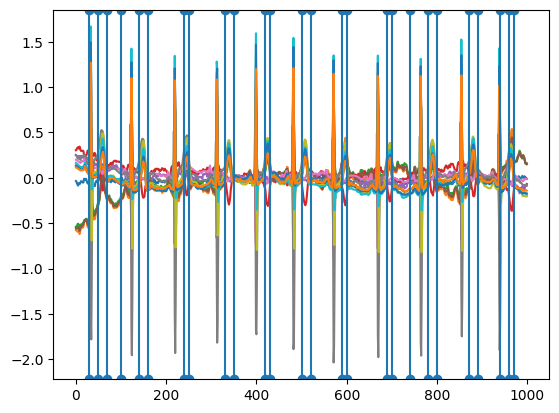

In [27]:
# Load and prepare data

# window_size = None
# path = './dataset/ecg/WFDB_PTBXL/ptbxl/'
# sampling_rate=100
# X_train, y_train, X_test, y_test = load_data(path, sampling_rate)

# TODO: preprocessing

model_inputs = []

# (19000, 1000, 12)
from numpy.typing import NDArray
import numpy as np
import pandas as pd
import ruptures as rpt
import matplotlib.pyplot as plt


def detect_changes(time_series: NDArray):

    # use 'l2', better for multivariate data
    algo = rpt.Pelt(model="rbf", min_size=5, jump=10).fit(time_series)
    result = algo.predict(pen=5)

    change_points = [i for i in result if i < len(time_series)]
    return change_points

for time_series in X_train[0:5]:
    
    change_points = detect_changes(time_series)
    plt.plot(time_series)

    for cp in change_points:
        plt.axvline(x=cp, marker='o', label="Time Series")

    plt.show()

    # # Tokenize the data
    # tokens = tokenize(torch.from_numpy(time_series), window_size, overlap, change_points)

    # # Generate positional encodings
    # pos_encoding = positional_encoding(tokens.shape[0], tokens.shape[1]).unsqueeze(-1) # (4, 442, 1)
    
    # model_input = torch.cat((tokens, pos_encoding), dim=-1)

    # model_inputs.append(model_input)


    

In [37]:
from numpy.typing import NDArray
import numpy as np
import pandas as pd
import ruptures as rpt
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from statsmodels.nonparametric.smoothers_lowess import lowess

def detect_changes(time_series: NDArray):

    # use 'l2', better for multivariate data
    algo = rpt.Pelt(model="rbf", min_size=5, jump=10).fit(time_series)
    result = algo.predict(pen=5)

    change_points = [i for i in result if i < len(time_series)]
    return change_points

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

# Function for Robust LOESS smoothing
def robust_loess(data, frac=0.1):
    return lowess(data, np.arange(len(data)), frac=frac, it=3)[:, 1]

# Function for Non-Local Means (adapted for time series)
def non_local_means(data, window_size=5, h=0.1):
    """
    Denoise time-series data using Non-Local Means.
    - window_size: size of the neighborhood for averaging.
    - h: filter parameter that controls the degree of smoothing.
    """
    denoised = np.copy(data)
    for i in range(len(data)):
        weights = np.exp(-np.abs(data[i] - data[max(0, i-window_size):min(i+window_size, len(data))])**2 / h)
        denoised[i] = np.sum(weights * data[max(0, i-window_size):min(i+window_size, len(data))]) / np.sum(weights)
    return denoised

for time_series in X_train[0:5]:
    times_series = bandpass_filter(time_series, 0.5, 50, 100)
    times_series = robust_loess(time_series)
    time_series = non_local_means(time_series)
    change_points = detect_changes(time_series)
    plt.plot(time_series)

    for cp in change_points:
        plt.axvline(x=cp, marker='o', label="Time Series")

    plt.show()


ValueError: Digital filter critical frequencies must be 0 < Wn < 1